# **Exploring Hurricane Tracks**

In this notebook, we reproduce some of the analysis carried out in "Classifying North Atlantic tropical cyclone tracks by mass moments." Journal of Climate 22.20 (2009): [5481-5494](https://journals.ametsoc.org/configurable/content/journals$002fclim$002f22$002f20$002f2009jcli2828.1.xml?t:ac=journals%24002fclim%24002f22%24002f20%24002f2009jcli2828.1.xml) by Nakamura, Jennifer, et al.

This notebook (a Python-based JupyterNotebook) provides a set of starter codes for [LEAP CPC Spring 2025](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges) [**Project 1**](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges#project-cycle-1-individual-notebook-for-exploratory-data-analysis) on

+ how to work with x-array data (given the hurricane tracks data),
+ how to visualize tracks and their moments,
+ how to carry out basic analysis on the hurricane data,
+ how to do k-means with the moments based on the paper's original idea.

All the codes in this notebook can be modified to implement research ideas.  



- Github sharing is recommended.
    - See our Github [tutorial](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges/blob/main/Tutorials/Github-Tutorial.md).
    - If you need help, please reach out to TA Xinyi Ke xk2161@columbia.edu.




# Step 0: Setup workspace

In [2]:
import os
cwd=os.getcwd()

cwd_data=cwd+'/data'

if not os.path.exists(cwd_data):
    os.mkdir(cwd_data)


Setup a subfolder for downloaded raw data and another subfolder for outputs. This prevents you from overwrites raw data by accident.

You can check that this new folder called 'data' was created. To view the files in your workspace, click on the 'File Browser' buttom at the left side-bar.

This folder will be used to store data which will be later downloaded.

---



# Step 1: Install packages, import packages and download data


## 1.1 Packages

Download the required packges.

In [3]:
%%capture
# These uninstallation must be done to ensure that no version conflicts would happen.
!pip uninstall --yes cartopy
!pip uninstall --yes shapely
# Shapely and cartopy are used for graphing maps and tracks.
!pip install shapely cartopy
!pip install gender_guesser

In [4]:
import cartopy.crs as ccrs # used for map projection
import matplotlib.pyplot as plt # matplotlib
import cartopy.feature as cfeature # used for map projection
import xarray as xr # x-array
import numpy as np # numpy
import urllib.request # download request
import warnings # to suppress warnings
import gender_guesser.detector as gender # for analyzing the names of hurricanes
from numpy import linalg as LA # to plot the moments (by calculating the eigenvalues)
from sklearn.cluster import k_means # to perform k-means
from collections import Counter # set operations
import urllib
warnings.filterwarnings('ignore')

## 1.2 Load Hurricane Data

Useful links to read more about data:

* [Official website for IBTrACS](https://www.ncdc.noaa.gov/ibtracs/). (where the data comes from)

* [Tracks in other basins for IBTrACs (other than NA)](https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/) (The data downloaded below covers the tracks in the basin 'NA' (North America). So, if you want to study tracks or hurricanes from other basins, this link might be helpful.)

* Another source of data: [HURDAT2](https://oasishub.co/dataset/hurdat-2-atlantic-hurricane-database/resource/2c865c53-3fc3-4e16-9ef5-0d76a47cfcf3) (not used in this notebook, but might be useful)



*   General documentation of the data: https://www.ncdc.noaa.gov/ibtracs/pdf/IBTrACS_version4_Technical_Details.pdf
*   Detailed documentation on each variable(this is particularly helpful if you want to dig more into the dataset and find what problems you are interested in solving regarding the track data): https://www.ncdc.noaa.gov/ibtracs/pdf/IBTrACS_v04_column_documentation.pdf


In [5]:
import requests

# IBTrACS.NA.v04r00.nc presents data from 1842-10-25 through 2023-06-07 
url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc'
output_file = 'data/NA_data.nc'

try:
    response = requests.get(url, timeout=60)
    response.raise_for_status()  # Raise an error for HTTP codes >= 400
    with open(output_file, 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully.")
except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")


File downloaded successfully.


In [6]:
# Download the needed track file
filedata = urllib.request.urlopen('https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc')

datatowrite = filedata.read()

with open('data/NA_data.nc', 'wb') as f:   
    f.write(datatowrite)

Now, check the /data directory (left panell( to see if the data `NA_data.nc` has been saved there.

# Step 2: Visualization of hurricane tracks






In this section, the notebooks give examples on how to plot tracks on a map on locations specified by users.

All the codes in this section can be directly used or modified to allow more features in later works.

## 2.1 Map background

This function plots a background map with parameters label and extent.



*   **label**: boolean, to short label or not on the output map background
*   **extent**: this controls where the projection appears, i.e., which part of earth map should appear on the projection. Its four entries can be viewd as (starting_longitude, ending_longitude, starting_latitude, ending_latitude).



In [7]:
def map_background(label=False, extent=[-100, 0, 0, 60]):
  # A helpder function for creating the map background.
  # INPUT:
  # "extent": corresponds to the location information of the showed map.
  # "label": boolean

  # OUTPUT:
  # Matplotlib AXES object

  plt.figure(figsize = (20, 10))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.coastlines()
  ax.set_extent(extent)
  ax.gridlines(draw_labels=label) # show labels or not
  LAND = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                      edgecolor='face',
                                      facecolor=cfeature.COLORS['land'],
                                          linewidth=.1)
  OCEAN = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                       edgecolor='face',
                                       facecolor=cfeature.COLORS['water'], linewidth=.1)
  ax.add_feature(LAND, zorder=0)
  ax.add_feature(OCEAN)
  return ax

## 2.1.1 A simple example using the function.

Here, we plot a line between two Stanford and Berkeley using the above function.

Text(-122.1461, 37.4041, 'Stanford')

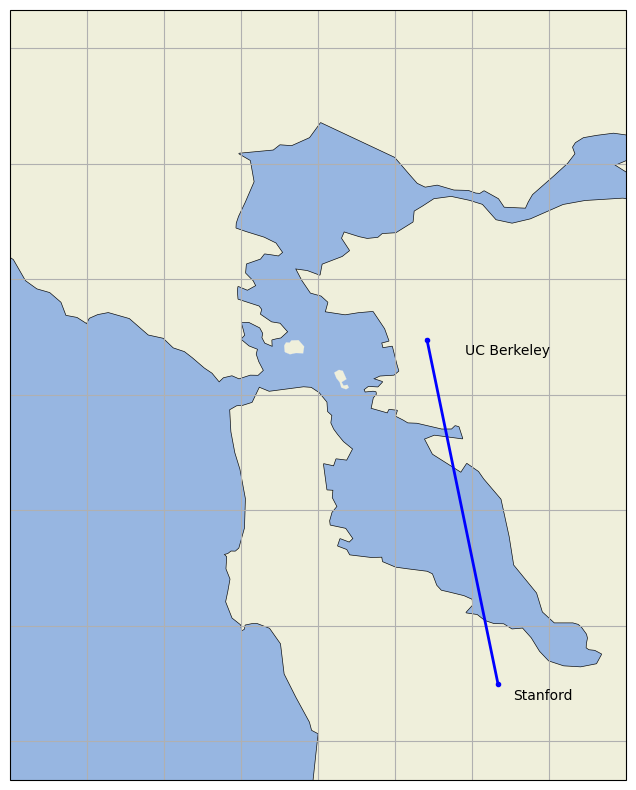

In [8]:
ax = map_background(extent=[-122.8, -122, 37.3, 38.3])

berkeley_lon, berkeley_lat = -122.2585, 37.8719
stanford_lon, stanford_lat = -122.1661, 37.4241

# plot the two universities as blue dots
ax.plot([berkeley_lon, stanford_lon], [berkeley_lat, stanford_lat],
         color='blue', linewidth=2, marker='.')
ax.text(berkeley_lon + 0.16, berkeley_lat - 0.02, 'UC Berkeley',
         horizontalalignment='right')
ax.text(stanford_lon + 0.02, stanford_lat - 0.02, 'Stanford',
         horizontalalignment='left')

\\

---

\\

## 2.2 Working with xarray data.

+ [Xarray documentation](https://xarray.pydata.org/en/stable/user-guide/terminology.html).
+ Read more about [data](https://earth-env-data-science.github.io/lectures/data.html).

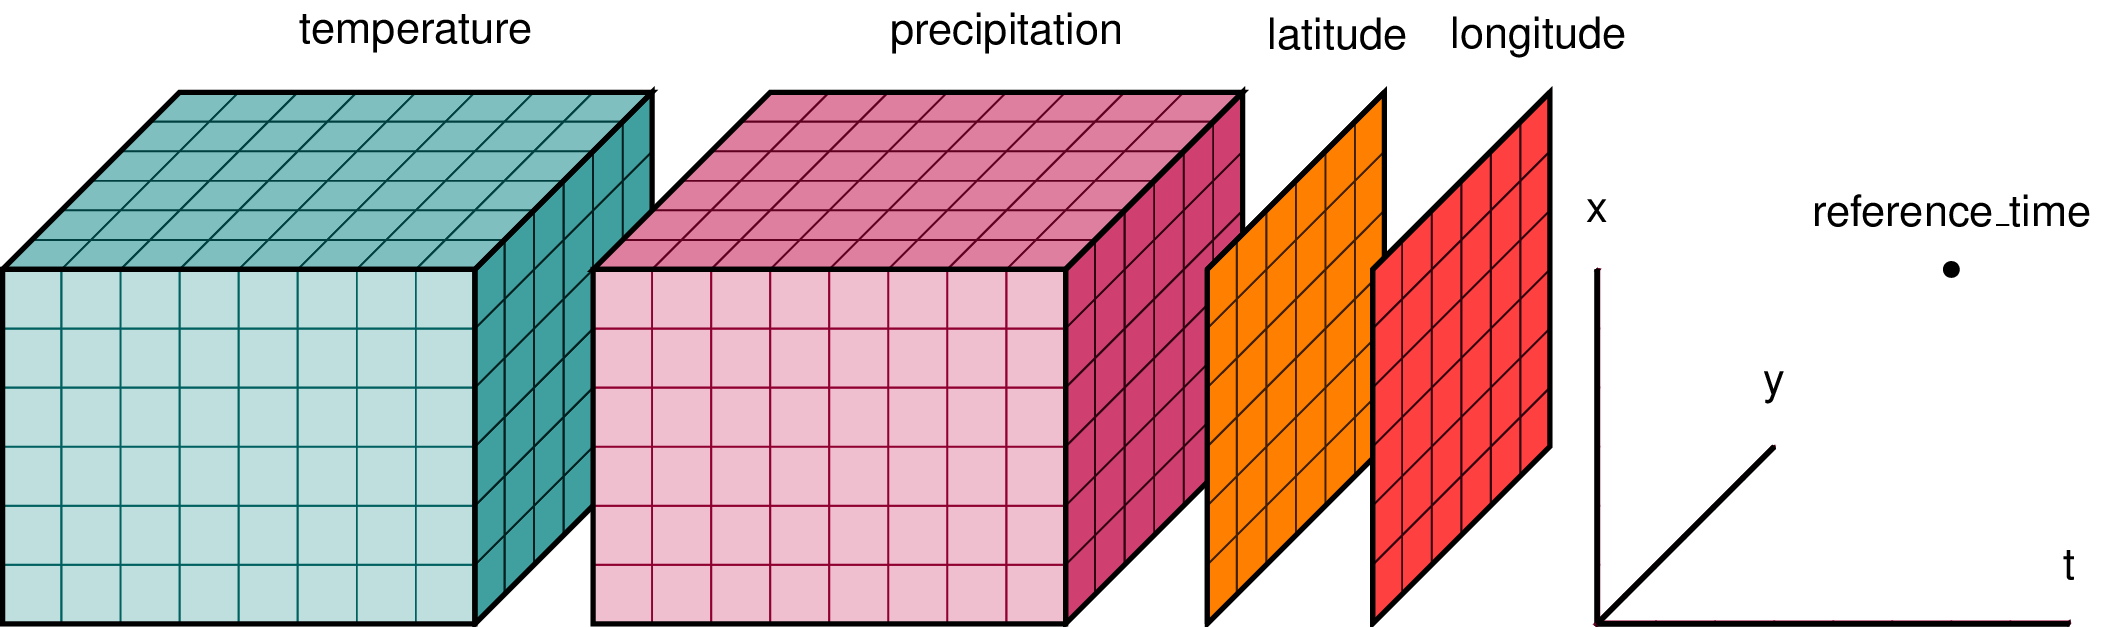


Even though the graph above has nothing to with the paper, the diagram (taken from x-array documentation website) illustrates the structure of xarray data (a Dataset in this case) works. In this example, we have the **axis** (x, y, t), **data** (temperature, precipitation, y, x). The latitude (y) and longitude (x) label the points along the dimensions, so they are the 'coordinate_data', while temperature and precipitation are 'actual' variables in a dataset. The latitude and longitude are 2D data in this case because the example used map projection. There can be an infinite amount of variables, but it would be unwise to have lots of axes and coordinates.

### 2.2.1 Explore the dataset of hurricanes and related systems

Run the code below to see an example of information that can be obtained from the original data.\
Read the output of the following code chunks to see some examples of operations we can carry out on the dataset.

In [9]:
tks = xr.open_dataset('data/NA_data.nc', engine="netcdf4", decode_times=False)

## Print the tks to take a peek at what's actually in the dataset.
print(tks)

<xarray.Dataset> Size: 618MB
Dimensions:           (storm: 2344, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) float64 7MB ...
    lat               (storm, date_time) float32 3MB ...
    lon               (storm, date_time) float32 3MB ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/147)
    numobs            (storm) float32 9kB ...
    sid               (storm) |S13 30kB ...
    season            (storm) float32 9kB ...
    number            (storm) int16 5kB ...
    basin             (storm, date_time) |S2 2MB ...
    subbasin          (storm, date_time) |S2 2MB ...
    ...                ...
    reunion_gust      (storm, date_time) float32 3MB ...
    reunion_gust_per  (storm, date_time) float32 3MB ...
    usa_seahgt        (storm, date_time) float32 3MB ...
    usa_searad        (storm, date_time, quadrant) float32 14MB ...
    storm_speed       (storm, date_time) float32 3MB ...
    storm_dir         (storm,

All the **coordinates** and **data variables** must align along the dimensions. **Attributes**, however, doesn't have to have shapes that aligned with at least one of the axes. It serves as a more auxiliary role in the dataset and provide other information that might be helpful.\
To obtain any variable from the dataset, for example 'xxx', use ***tks.xxx***.

In [ ]:
# for example, Storm_speed
print(tks.storm_speed)

In [174]:
## how many tracks in total, this is the same as the length of the dimension 'storm'
storm_num = tks.dims['storm']

## Note that the dimension 'quadrant' is often not used, which can be
## dropped if wanted by tks.drop_dims("quadrant")
print(f"\nDimension of the dataset is {dict(tks.dims)}")
print(f"\nIn total, there are {storm_num} track records.")
print(f"\nThe attributes of this dataset are:\n {list(tks.attrs.keys())}")


## starting and ending season (the same as year)
min_year = np.array(np.min(list(tks.season)), dtype=int)
max_year = np.array(np.max(list(tks.season)), dtype=int)

print(f"\nTrack records start in year {min_year} and ends in year {max_year}")

## Print all the variables in a list.
print('\nAll variables in this dataset:')
print(list(tks.keys()))


## Print a sentence that contians some summary information.
storm_1 = tks.sel(storm=2000) # notice that the first storm starts with 0 not 1
name = str(storm_1.name.values)[2:-1] # use this trick to obtain the name string
sid = str(storm_1.sid.values,'UTF-8')
print(f"\nThe 2001st hurricane, named {name}, has a record of {int(storm_1.numobs)} \
observations with sid {sid} in year {int(storm_1.season)}.")


Dimension of the dataset is {'storm': 2344, 'date_time': 360, 'quadrant': 4}

In total, there are 2344 track records.

The attributes of this dataset are:
 ['title', 'summary', 'source', 'Conventions', 'Conventions_note', 'product_version', 'project', 'processing_level', 'acknowledgement', 'references', 'institution', 'publisher_type', 'publisher_name', 'publisher_email', 'publisher_institution', 'publisher_url', 'creator_type', 'creator_name', 'creator_institution', 'creator_email', 'creator_url', 'contributor_name', 'contributor_role', 'date_created', 'date_issued', 'time_coverage_start', 'time_coverage_end', 'geospatial_lat_min', 'geospatial_lat_max', 'geospatial_lat_units', 'geospatial_lat_resolution', 'geospatial_lon_min', 'geospatial_lon_max', 'geospatial_lon_units', 'geospatial_lon_resolution', 'geospatial_vertical_min', 'geospatial_vertical_max', 'naming_authority', 'id', 'metadata_link', 'keywords', 'keywords_vocabulary', 'standard_name_vocabulary', 'history', 'license', 'fea

\\

---

\\

## 2.3 Visualizing a track or group of tracks

We use asterisk and X to denote the birth and death points of a track.

In [13]:
# These are helper functions to conveniently plot one single track.
def get_lon_lat(storm):
  lon_lst = storm.lon.values
  lat_lst = storm.lat.values
  return lon_lst[~np.isnan(lon_lst)], lat_lst[~np.isnan(lat_lst)]

# !!! Note that even though it's a convention to place latitude before longitude,
# to work with cartopy projection, longitude MUST be placed first. !!!
def plot_one_track(ax, storm, color='blue', all_track=True, marker_color='black'):
  # INPUT:
  # ax: Matplotlib axes object
  # storm: a Xarray DATASET object (this can be adjusted if desired)
  # all_track: plot the whole track or just the origin

  # OUTPUT:
  # None

  lon_lst, lat_lst = get_lon_lat(storm)
  year = storm.season.values
  if all_track:
    ax.plot(lon_lst, lat_lst, '-o', color=color, linewidth=2, markersize=3) # marker='.'
    ax.plot(lon_lst[-1], lat_lst[-1], color=marker_color, marker='x', markersize=10)
  ax.plot(lon_lst[0], lat_lst[0], color=marker_color, marker='*', markersize=10)
  ax.text(lon_lst[0], lat_lst[0]-2, str(storm.name.values)[2:-1], horizontalalignment='center')



## 2.3.1 Visualize all tracks in a year


In [ ]:
object = get_lon_lat(storm = tks.where(tks.name == 'Katrina'))
len(object[0])

In [ ]:
year=(range(2014, 2024))
print(year)

Use function to visualize all tracks in year 2017 (or whichever year you choose on first line)

In [ ]:
year=2017 # Change this to see tracks from other years.
storms = tks.where(tks.season==year, drop=True) # select the hurricanes that happened in selected year
print(f"There are {storms.dims['storm']} storms in the year {year}.\n")
storm_num = storms.dims['storm']
ax = map_background(extent=[-100, 0, 0, 60], label=True)

for ind in range(storm_num):
  storm = storms.sel(storm=ind)
  plot_one_track(ax, storm, color='orange')
plt.title(f"Tracks in year {year}")
# plt.legend()

\\

---

\\

# Step 3: Analyze Tracks

Here we use moment as a numerical characteristic of a track. [Ophelia (2005)](https://en.wikipedia.org/wiki/Hurricane_Ophelia_(2005)) is given as an example track.



## 3.1 Define the moments of a track

Below codes plot ONE track and its moments based on the paper's idea.

So, what we want to do here is to find a summary statistics for the track. Here the method below calculates the weighted first and second moments of a track, which would ouput a 5-entry vector which can be used in clustering and analysis purpose.

M1 here stands for the first moment. When the weights $w$ are set to 1, it simply calculating the means of the longitude and latitude vectors. Changing the weights to other variables, such as wind speed, storm speed, temperatures, etc. should result in different clustering. In the paper, setting all the weights to 1 is used.

M2 stands for the second moment. When the weights are 1, it is calculating the variances and covariance of longitude and latitude vectors of a given track.

$r$ is a two-dimensional vector that corresponds to $(x,y)$, i.e., longitude and latitude.

See [Nakamura et al (2009)](https://journals.ametsoc.org/configurable/content/journals$002fclim$002f22$002f20$002f2009jcli2828.1.xml?t:ac=journals%24002fclim%24002f22%24002f20%24002f2009jcli2828.1.xml) for more details on the notation.

$$
\begin{aligned}
\mathbf{M 1}&=\frac{1}{A} \int w(\mathbf{r}) \mathbf{r} d x d y=\frac{1}{\sum_{i=1}^{n} w\left(r_{i}\right)} \sum_{i=1}^{n} w\left(\mathbf{r}_{i}\right) \mathbf{r}_{i} \\
\mathbf{M 2} &=\frac{1}{A} \int w(\mathbf{r})(\mathbf{r}-\mathbf{M 1})^{2} d x d y
=\frac{1}{\sum_{i=1}^{n} w\left(r_{i}\right)} \sum_{i=1}^{n} w\left(\mathbf{r}_{i}\right)\left(\mathbf{r}_{i}-\mathbf{M 1}_{i}\right)^{2}
\end{aligned}
$$


## 3.1.1 Function to calculate moment for a system

This function outputs a length-5 vector that summaries the moments of a track as specified in the above description.


In [ ]:
def get_moments(storm):
  # A function to calculate the track moments given a storm
  # OUTPUT:
  # X-centroid, Y-centroid, X_var, Y_var, XY_var

  # Note that:
  # In this case, no weights are set. In other words, all weights are 1.
  # A weight variable would need to be added in order to explore other weights

  lon_lst, lat_lst = get_lon_lat(storm)
  # If the track only has one point, there is no point in calculating the moments
  if len(lon_lst)<= 1: return None
      
  # M1 (first moment = mean). 
  # No weights applied
  lon_weighted, lat_weighted = np.mean(lon_lst), np.mean(lat_lst)
    
  # M2 (second moment = variance of lat and of lon / covariance of lat to lon
  # No weights applied
  cv = np.ma.cov([lon_lst, lat_lst])
    
  return [lon_weighted, lat_weighted, cv[0, 0], cv[1, 1], cv[0, 1]]

## 3.1.2 Calculate moments and visualize for one system

In [ ]:
storm = tks.sel(storm=2053)
lon_weighted, lat_weighted, lon_var, lat_var, xy_var = get_moments(storm)

# Rotate the circle and calculate points on the circle
# Set N larger to make the oval more precise and to consume more electricity
N=1000
t = np.linspace(0, 2 * np.pi, N)
circle = [np.sqrt(lon_var) * np.cos(t), np.sqrt(lat_var) * np.sin(t)]
_, R_rot = LA.eig(np.array([[lon_var, xy_var], [xy_var, lat_var]]))
circle = np.dot(R_rot, circle)
R_1, R_2 = circle[0, :] + lon_weighted, circle[1, :] + lat_weighted

# Plot
ax = map_background(extent=[-100, 20, 0, 80], label=True)
plot_one_track(ax, storm)
ax.plot(R_1, R_2, '-', color='black', linewidth=1)
ax.plot([circle[0,0], circle[0,int(N/2)]]+lon_weighted,
        [circle[1,0], circle[1,int(N/2)]]+lat_weighted, '-gh')
ax.plot([circle[0,int(N/4)], circle[0,int(N*3/4)]]+lon_weighted,
        [circle[1,int(N/4)], circle[1,int(N*3/4)]]+lat_weighted, '-gh')

## 3.2 K-means clustering using moments for all systems

In this section, K-means clustering is carried out on the historical tracks with the idea adopted from the paper. As the data are different, nuances with the clustering results are expected.

In [ ]:
# It takes a moment to calculate the moments.
moment_lst = [get_moments(tks.sel(storm=i)) for i in range(tks.dims['storm'])
              if get_moments(tks.sel(storm=i))]
print(np.shape(moment_lst))
print(f"There are {tks.dims['storm']-np.shape(moment_lst)[0]} tracks that have length less than 1.")

In [ ]:
short_tracks = sum(len(get_lon_lat(tks.sel(storm=i))[0]) <= 1 for i in range(tks.dims['storm']))
print(f"Number of storms with 1 or fewer points: {short_tracks}")

### 3.2.1 Find inertia values to determine the right number of clusters

Run the clustering for a range of cluster numbers and extract the interia value

Inertia values from sklearn are evaluated with the "elbow method" to determine the optimal value of the clusters.\
Inertia, or cost, is calculated as the sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided. See the documentation for [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) for more details.

In [ ]:
sum_of_squares = []
K = range(1, 15)
for k in K:
    km = k_means(moment_lst, n_clusters=k)
    sum_of_squares.append(km[2])
plt.plot(K, sum_of_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Inertia Values against the Number of Cluster k')

From the plot above, 6 is probably a good choice for the number of clusters.\
Below codes plot the K-means results. The locations on the map are the weighted first moment of the hurricane tracks. In the example code, the weights were set to be 1 meaning that the first moment is the sample mean (see section 3.1 description).

Note that if you run the code again the ordering of the clusters changes

In [ ]:
km = k_means(moment_lst, n_clusters=6)
# print(km[0])

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta']
labels_tks = km[1]
ax = map_background()
for k in range(len(moment_lst)):
    ax.plot(moment_lst[k][0], moment_lst[k][1], c=colors[labels_tks[k]], marker='*')
plt.title('K-means clustering result, 6 clusters')

In [ ]:
# consider a different number of clusters (colors set for up to 12, add more colors if you want more clusters)
km = k_means(moment_lst, n_clusters=12)
# print(km[0])

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta','orange','gray','white','cyan','purple','brown']
labels_tks = km[1]
ax = map_background()
for k in range(len(moment_lst)):
    ax.plot(moment_lst[k][0], moment_lst[k][1], c=colors[labels_tks[k]], marker='*')
plt.title('K-means clustering result')

## 3.5 Other Summary Statistics and example comparisons

### 3.5.1 Distance traveled

Compare the $\Delta$ lon and $\Delta$ lat between these two interval of years (2000\~2010 against 1990\~1999).\
$\Delta$ lon is the maximum value of distance of travel of a hurricane from its start to its end location in its longitude (same as the what [np.ptp](https://numpy.org/doc/stable/reference/generated/numpy.ptp.html) does).

In [ ]:
def delta_lon_lat(storm):
  lon_lst, lat_lst = get_lon_lat(storm)
  return [np.ptp(lon_lst), np.ptp(lat_lst)]

storms_1 = tks.where((tks.season >= 2000) & (tks.season <= 2010), drop=True)
storms_2 = tks.where((tks.season >= 1990) & (tks.season <= 1999), drop=True)
N1, N2 = storms_1.dims['storm'], storms_2.dims['storm']
print(f"{storms_1.dims['storm']} storms between year 2000 and 2010, \
        {storms_2.dims['storm']} storms between year 1990 and 1999.\n")

d_lst_1 = [delta_lon_lat(storms_1.sel(storm=i)) for i in range(N1)]
d_lst_1 = np.transpose(d_lst_1)

d_lst_2 = [delta_lon_lat(storms_2.sel(storm=i)) for i in range(N2)]
d_lst_2 = np.transpose(d_lst_2)


fig, axs = plt.subplots(1,2,figsize=(8,3)) # gridspec_kw={'height_ratios': [1, 2]}

for j in range(2):
  axs[j].hist(d_lst_1[j], label='2000~2010')
  axs[j].hist(d_lst_2[j], label='1990~1999')
  axs[j].legend()
axs[0].title.set_text('Delta longitude')
axs[1].title.set_text('Delta latitude')



It can be seen from the above graphs that hurricanes traveled greater distance in 2000\~2010 compared to 1990~1999.

### 3.5.2 Naming hurricanes

Many hurricane in the data set have a name. We use the codes below to visualize the predominant gender of the names used.

Here is some [history of the hurricane naming system](https://www.nhc.noaa.gov/aboutnames_history.shtml):

+ 1953 - 1977: The United States only used female names for hurricanes.
+ 1978 - present: Both female and male names are used.

We use the [gender.Detector](https://pypi.org/project/gender-guesser/) to automatically infer the predominant gender of each name found in the data set.

Note that in the output below, a very few percentage of names are marked 'Andy' which means it's a gender-neutral or an unisex name (are you woke enough?).

In [ ]:
def plot_pie_chart(storms, period):
  # a function to plot pie chart the genders of names given a bunch of storms

  all_names = [str(name)[2:-1] for name in storms.name.values]
  all_names = [x for x in all_names if x!='NOT_NAMED'] # clean the unnamed cases
  print(f"In total there are {len(all_names)} named hurricanes {period}.\n")

  gender_lst = [d.get_gender(name) for name in all_names]
  gender_lst = [x for x in gender_lst if x!='unknown'] # clean the unknown names

  # Data (counts)
  genders_category = Counter(gender_lst).keys()  # equals to list(set(list))
  genders_count = Counter(gender_lst).values() # counts the elements' frequency
  explode = [0.11 if x==max(genders_count) else 0 for x in genders_count]

  # plot
  fig1, ax1 = plt.subplots()
  ax1.pie(genders_count, explode=explode, labels=genders_category, autopct='%1.1f%%',
          shadow=True, startangle=0)
  ax1.axis('equal')
  ax1.title.set_text(f'Gender counts for names {period}')



d = gender.Detector(case_sensitive=False)
gen = d.get_gender("Ophelia")
print(f"Ophelia is deemed a {gen} name.\n")
storms = tks.where((tks.season >=1953)&(tks.season <=1979), drop=True)
storms_1 = tks.where((tks.season >=1979), drop=True)

plot_pie_chart(storms, period='during 1953-1979')
plot_pie_chart(storms_1, period='after 1979')


### 3.5.3 Not all systems are hurricanes. Classification of systems - hurricane? tropical storm? tropical depression? 

Below codes summarize the types of all the classified hurricanes in the record (in the NA basin).

Storm classification by usa_status (according the documentation this is not the unique way of classifying the tracks)

Status of system. Options:
* DB - disturbance,
* TD - tropical depression,
* TS - tropical storm,
* TY - typhoon,
* ST - super typhoon,
* TC - tropical cyclone,
* HU,HR - hurricane,
* SD - subtropical depression,
* SS - subtropical storm,
* EX - extratropical systems,
* PT - post tropical,
* IN - inland,
* DS - dissipating,
* LO - low,
* WV - tropical wave,
* ET - extrapolated,
* MD - monsoon depression,
* XX - unknown.
 
documentation at https://www.ncei.noaa.gov/sites/default/files/2021-07/IBTrACS_v04_column_documentation.pdf

In [ ]:
all_types = tks.usa_status.values
print(np.shape(all_types))

Notice the shape is (2344, 360), indicating that the classification of each system evolves along the 'date_time' axis. \
To identify a class for system across its whole track, we can define it as the one class that has the highest frequency throughout its lifetime.


In [ ]:
class_lst = []

for i in range(tks.dims['storm']):
  types = [str(x)[2:-1] for x in all_types[i]]
  types = [x for x in types if x!='']
  # many of the recorded tracks are never given a class
  if len(types)==0: continue
  class_category = Counter(types).most_common(1)[0][0] # Select the most frequent class
  class_lst.append(class_category)

print(f'There are {len(class_lst)} systems in the North Atlantic that were classified at \
least once during its lifetime.\n')

# This helps center the labels.
labels, counts = np.unique(class_lst, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title('Counts of the classification of all the tracks')

# References

+ Nakamura, Jennifer, et al. "Classifying North Atlantic tropical cyclone tracks by mass moments." Journal of Climate 22.20 (2009): [5481-5494](https://journals.ametsoc.org/configurable/content/journals$002fclim$002f22$002f20$002f2009jcli2828.1.xml?t:ac=journals%24002fclim%24002f22%24002f20%24002f2009jcli2828.1.xml).

+ Nakamura, Jennifer, et al. "Western North Pacific tropical cyclone model tracks in present and future climates." Journal of Geophysical Research: Atmospheres 122.18 (2017): [9721-9744](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017JD027007).

In [ ]:
####START GIVEN NEW PROJECT IDEA####

In [14]:
#Filter storm dataset to include only storms which make landfall at some point
landfall_mask = tks.groupby('storm').map(lambda x: (x.landfall == 0).any())

# Extract the storm IDs where landfall occurs
storms_with_landfall = landfall_mask.storm[landfall_mask]

# Step 2: Filter the dataset to include only these storms
filtered_tks0 = tks.sel(storm=storms_with_landfall)

In [15]:
#Filter storms to only include storms in the seasons for which we have blackout data
lower_year = 2014 
upper_year = 2023 

def passes_year(storm):
    """Check if the storm occurred in the period of interest."""
    return ((storm.season <= upper_year) & (storm.season >= lower_year)).any()

# Apply the function to each storm and get a boolean array
year_mask = filtered_tks0.groupby('storm').map(passes_year)

# Extract the storm IDs for storms in those seassons
storms_within_year = year_mask.storm[year_mask]

# Step 2: Filter the dataset to include only these storms
filtered_tks = filtered_tks0.sel(storm=storms_within_year)

There are 12 storms in the year 2017.



Text(0.5, 1.0, 'Tracks in year 2017')

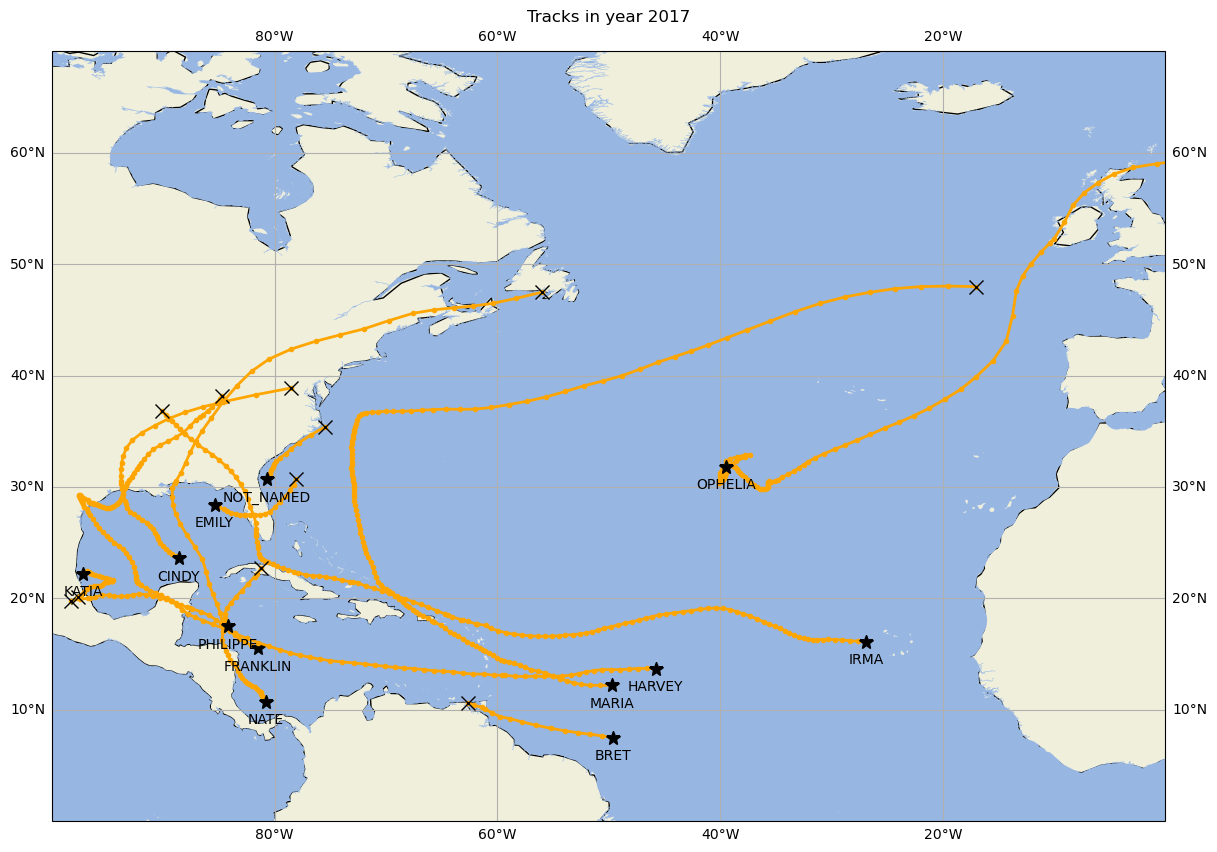

In [16]:
#Plot one year of the filtered (landfall and year) dataset to make sure it looks right
year=2017 # Change this to see tracks from other years.
storms = filtered_tks.where(filtered_tks.season==year, drop=True) # select the hurricanes that happened in selected year
print(f"There are {storms.dims['storm']} storms in the year {year}.\n")
storm_num = storms.dims['storm']
ax = map_background(extent=[-100, 0, 0, 60], label=True)

for ind in range(storm_num):
  storm = storms.sel(storm=ind)
  plot_one_track(ax, storm, color='orange')
plt.title(f"Tracks in year {year}")
# plt.legend()

In [17]:
#Filter all storms to include only those which pass through the CONUS box
longitude_boundary = -66.9503  #Easternmost point in CONUS (Maine)
latitude_boundary = 24.5465 #Southernmost point in CONUS (Key West)

def passes_boundary(storm):
    """Check if the storm passes through the specified geographical boundary at any point."""
    return ((storm.lon <= longitude_boundary) & (storm.lat >= latitude_boundary)).any()

# Apply the function to each storm and get a boolean array
boundary_mask = filtered_tks.groupby('storm').map(passes_boundary)

# Extract the storm IDs that pass through the boundary
storms_within_boundary = boundary_mask.storm[boundary_mask]

# Step 2: Filter the dataset to include only these storms
filtered_tks2 = filtered_tks.sel(storm=storms_within_boundary)

There are 7 storms in the year 2017.



Text(0.5, 1.0, 'Tracks in year 2017')

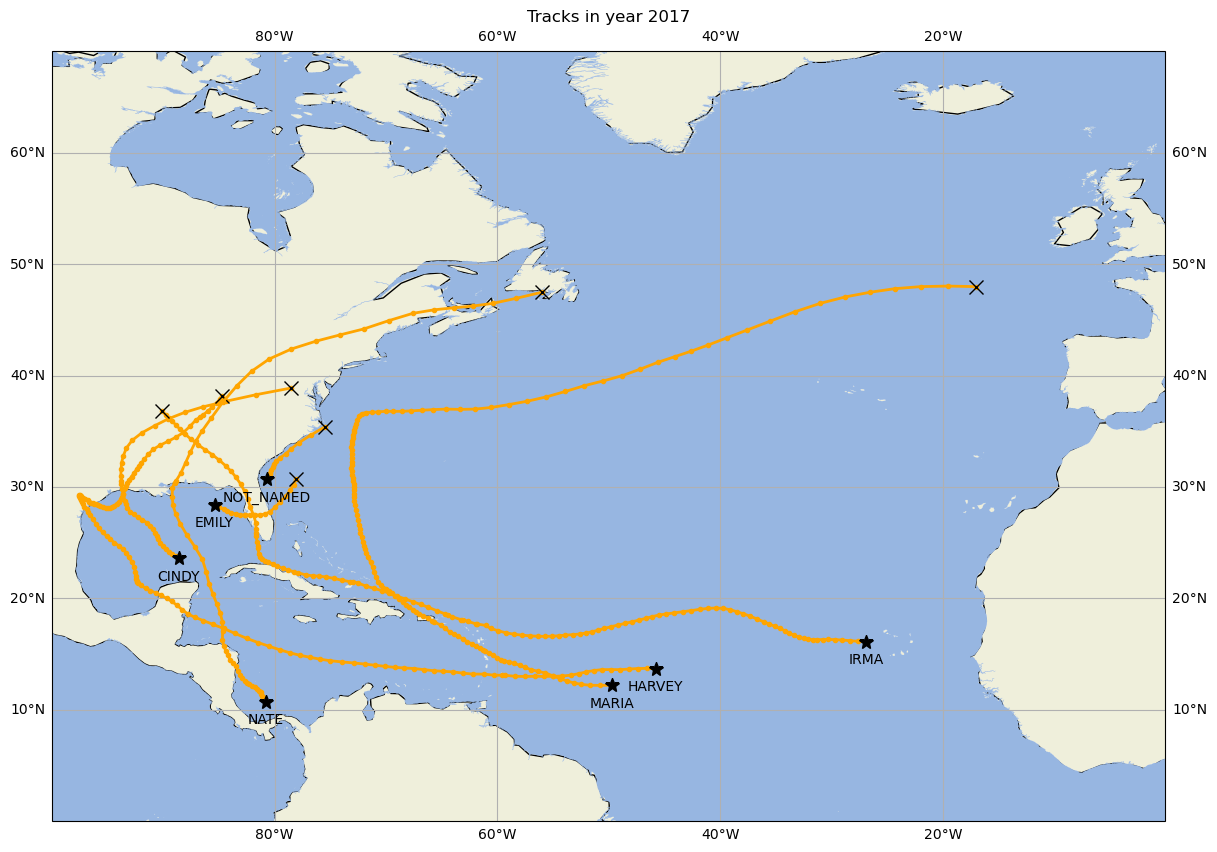

In [18]:
#Plot one year of the filtered (landfall, year, and CONUS) dataset to make sure it looks right
year=2017 # Change this to see tracks from other years.
storms = filtered_tks2.where(filtered_tks2.season==year, drop=True) # select the hurricanes that happened in selected year
print(f"There are {storms.dims['storm']} storms in the year {year}.\n")
storm_num = storms.dims['storm']
ax = map_background(extent=[-100, 0, 0, 60], label=True)

for ind in range(storm_num):
  storm = storms.sel(storm=ind)
  plot_one_track(ax, storm, color='orange')
plt.title(f"Tracks in year {year}")
# plt.legend()

There are 62 storms in the area of interest


Text(0.5, 1.0, 'Tracks which made landfall plus passed west of Maine and north of Florida between 2014-2023')

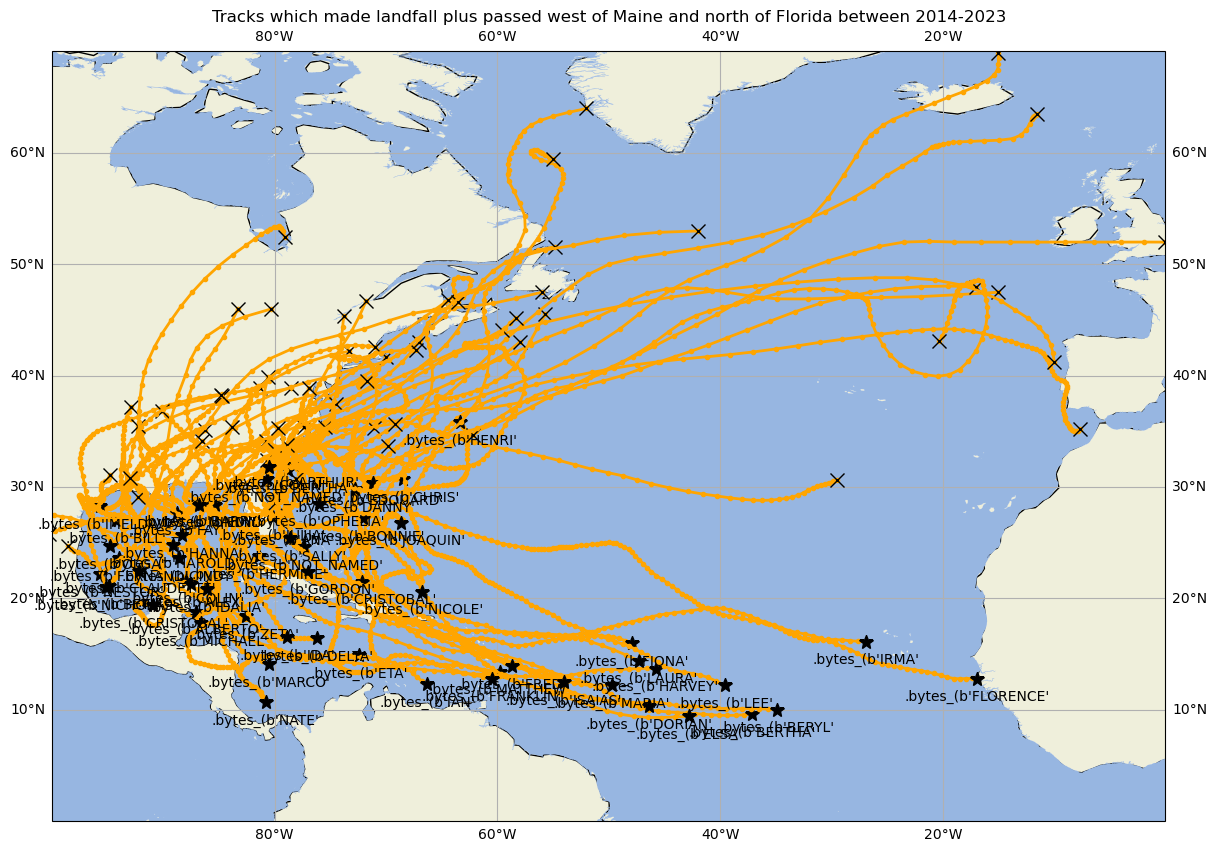

In [19]:
# plot all the storms in the area of interest
storms = filtered_tks2 
print(f"There are {storms.dims['storm']} storms in the area of interest")
storm_num = storms.dims['storm']
ax = map_background(extent=[-100, 0, 0, 60], label=True)

for ind in range(storm_num):
  storm = storms.sel(storm=ind)
  plot_one_track(ax, storm, color='orange')
plt.title(f"Tracks which made landfall plus passed west of Maine and north of Florida between 2014-2023")

In [20]:
#Define a function to return the track for which a storm is making landfall
def get_landfall_lon_lat(storm):
    """Returns the longitude and latitude values where the landfall variable is equal to zero."""
    #storm['landfall'] = storm['landfall'].astype(int)
    # Filter the storm data where landfall is equal to zero
    filtered_storm = storm.where(storm.landfall == 0, drop=True)
    
    # Extract longitude and latitude values
    lon_lst = filtered_storm.lon.values
    lat_lst = filtered_storm.lat.values
    
    # Remove NaN values
    lon_lst = lon_lst[~np.isnan(lon_lst)]
    lat_lst = lat_lst[~np.isnan(lat_lst)]
    
    return lon_lst, lat_lst

In [21]:
#Define a function to get the first and second moments for the landfall portion of a storm's track
def get_landfall_moments(storm):
  # A function to calculate the track moments given a storm
  # OUTPUT:
  # X-centroid, Y-centroid, X_var, Y_var, XY_var

  # Note that:
  # In this case, no weights are set. In other words, all weights are 1.
  # A weight variable would need to be added in order to explore other weights

  lon_lst, lat_lst = get_landfall_lon_lat(storm)
  # If the track only has one point, there is no point in calculating the moments
  if len(lon_lst)<= 1: return None
      
  # M1 (first moment = mean). 
  # No weights applied
  lon_weighted, lat_weighted = np.mean(lon_lst), np.mean(lat_lst)
    
  # M2 (second moment = variance of lat and of lon / covariance of lat to lon
  # No weights applied
  cv = np.ma.cov([lon_lst, lat_lst])
    
  return [lon_weighted, lat_weighted, cv[0, 0], cv[1, 1], cv[0, 1]]

In [22]:
#plot example to demonstrate where the new landfall moment ellipse is
N=1000
t = np.linspace(0, 2 * np.pi, N)
circle = [np.sqrt(lon_var) * np.cos(t), np.sqrt(lat_var) * np.sin(t)]
_, R_rot = LA.eig(np.array([[lon_var, xy_var], [xy_var, lat_var]]))
circle = np.dot(R_rot, circle)
R_1, R_2 = circle[0, :] + lon_weighted, circle[1, :] + lat_weighted

# Plot
ax = map_background(extent=[-100, 20, 0, 80], label=True)
plot_one_track(ax, storm)
ax.plot(R_1, R_2, '-', color='black', linewidth=1)
ax.plot([circle[0,0], circle[0,int(N/2)]]+lon_weighted,
        [circle[1,0], circle[1,int(N/2)]]+lat_weighted, '-gh')
ax.plot([circle[0,int(N/4)], circle[0,int(N*3/4)]]+lon_weighted,
        [circle[1,int(N/4)], circle[1,int(N*3/4)]]+lat_weighted, '-gh')

NameError: name 'lon_var' is not defined

In [23]:
#Get the landfall moment list for all storms in the filtered (landfall, year, CONUS) dataset
moment_landfall = [get_landfall_moments(filtered_tks2.sel(storm=i)) for i in range(filtered_tks2.dims['storm']) if get_landfall_moments(filtered_tks2.sel(storm=i))]


Text(0.5, 1.0, 'Inertia Values against the Number of Cluster k')

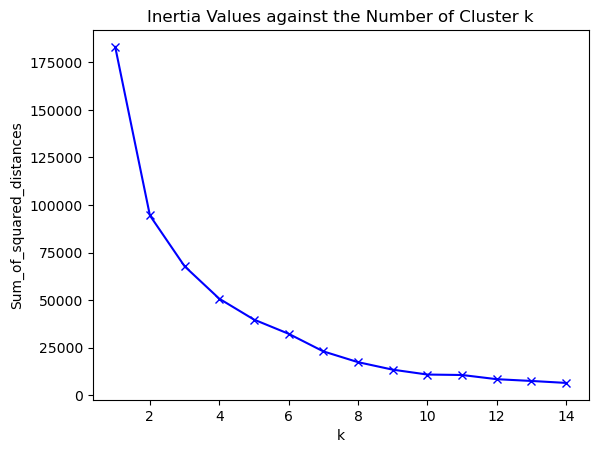

In [24]:
#Identify the proper number of clusters for clustering by landfall moments (ie swath location and width)
sum_of_squares = []
K = range(1, 15)
for k in K:
    km = k_means(moment_landfall, n_clusters=k)
    sum_of_squares.append(km[2])
plt.plot(K, sum_of_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Inertia Values against the Number of Cluster k')

Text(0.5, 1.0, 'K-means clustering result, 6 clusters')

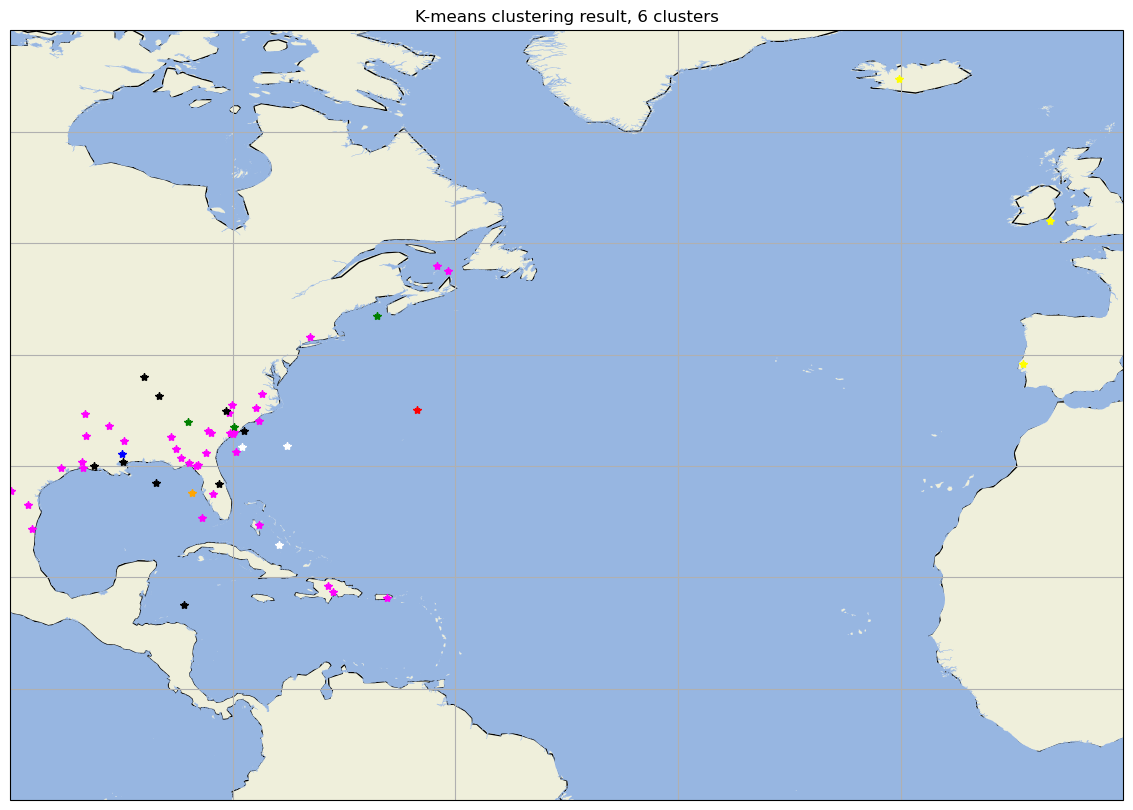

In [25]:
#Plot clustering from landfall moments
km_landfall = k_means(moment_landfall, n_clusters=8)
# print(km[0])

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta', 'orange', 'white']
labels_landfall = km_landfall[1]
ax = map_background()
for k in range(len(moment_landfall)):
    ax.plot(moment_landfall[k][0], moment_landfall[k][1], c=colors[labels_landfall[k]], marker='*')
plt.title('K-means clustering result, 6 clusters')

In [26]:
#Filter moment list to include only storms where the moment lies within the CONUS box
#This gets rid of storms that passed through the CONUS box but had the majority of their landfall elsewhere (e.g Central America or Europe)
longitude_boundary = -66.9503  
latitude_boundary = 24.5465 
moment_landfall_array = np.array(moment_landfall)
filtered_moment_landfall = moment_landfall_array[(moment_landfall_array[:, 0] <= longitude_boundary) & (moment_landfall_array[:, 1] >= latitude_boundary)]

Text(0.5, 1.0, 'Inertia Values against the Number of Cluster k')

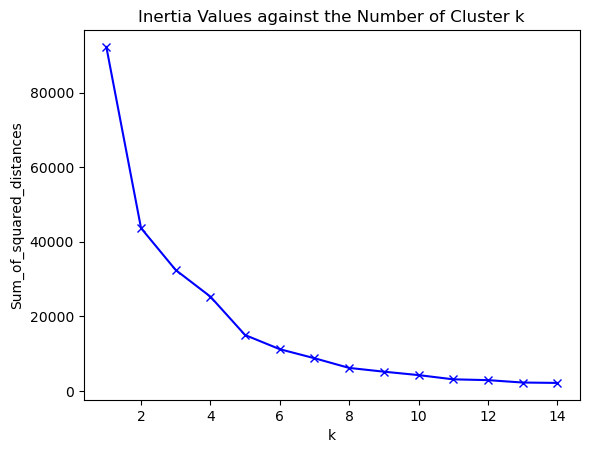

In [27]:
#Identify number of clusters for clustering by landfall location and swath
sum_of_squares = []
K = range(1, 15)
for k in K:
    km = k_means(filtered_moment_landfall, n_clusters=k)
    sum_of_squares.append(km[2])
plt.plot(K, sum_of_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Inertia Values against the Number of Cluster k')

Text(0.5, 1.0, 'K-means clustering result, 7 clusters')

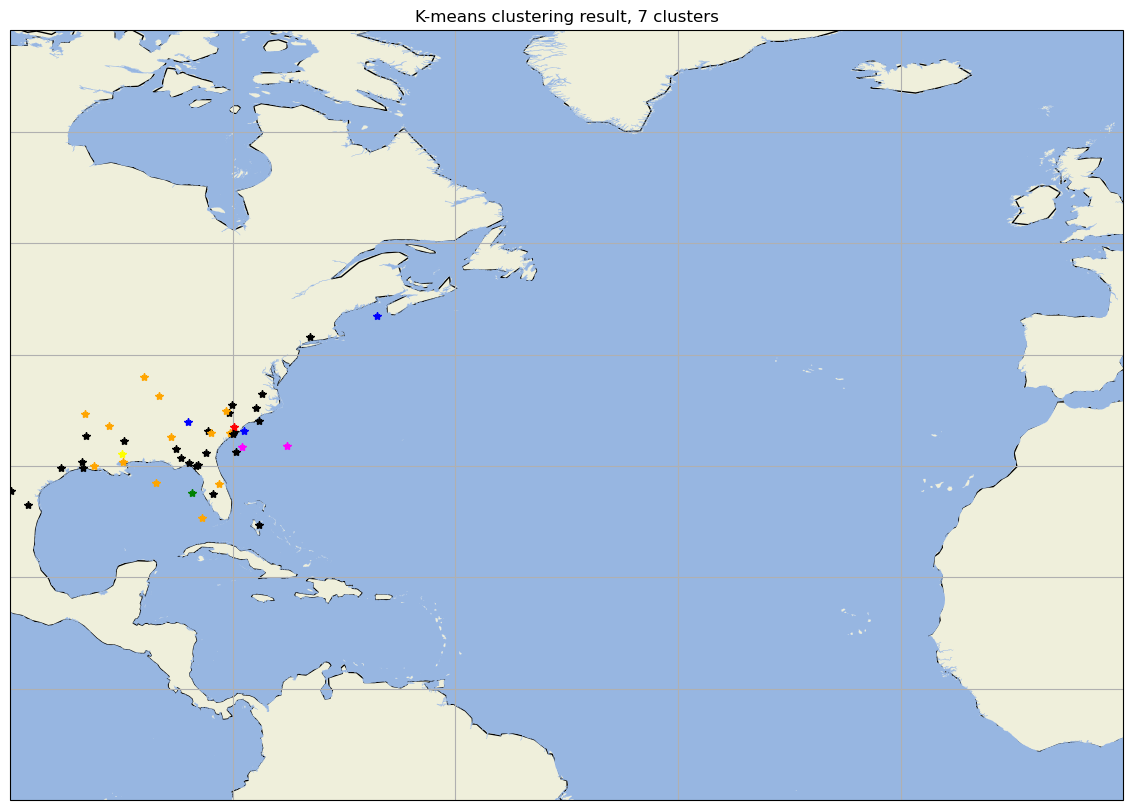

In [28]:
#CLuster by landfall location and swath for only storms with the landfall moments in the CONUS box
km_landfall_filt = k_means(filtered_moment_landfall, n_clusters=7)
# print(km[0])

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta', 'orange', 'white', 'purple', 'teal']
labels_landfall_filt = km_landfall_filt[1]
ax = map_background()
for k in range(len(filtered_moment_landfall)):
    ax.plot(filtered_moment_landfall[k][0], filtered_moment_landfall[k][1], c=colors[labels_landfall_filt[k]], marker='*')
plt.title('K-means clustering result, 7 clusters')

In [29]:
#Make a moment list with only the first two (lat and long) items in the landfall moment list to cluster by landfall location only (NOT swath width)
moment_landfall_spat = filtered_moment_landfall[:, :2]

Text(0.5, 1.0, 'Inertia Values against the Number of Cluster k')

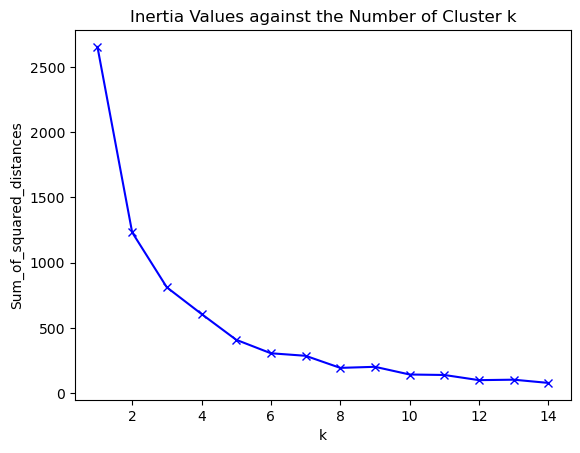

In [30]:
#Identify number of clusters for clustering by landfall location only
sum_of_squares = []
K = range(1, 15)
for k in K:
    km = k_means(moment_landfall_spat, n_clusters=k)
    sum_of_squares.append(km[2])
plt.plot(K, sum_of_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Inertia Values against the Number of Cluster k')

Text(0.5, 1.0, 'K-means clustering result, 7 clusters')

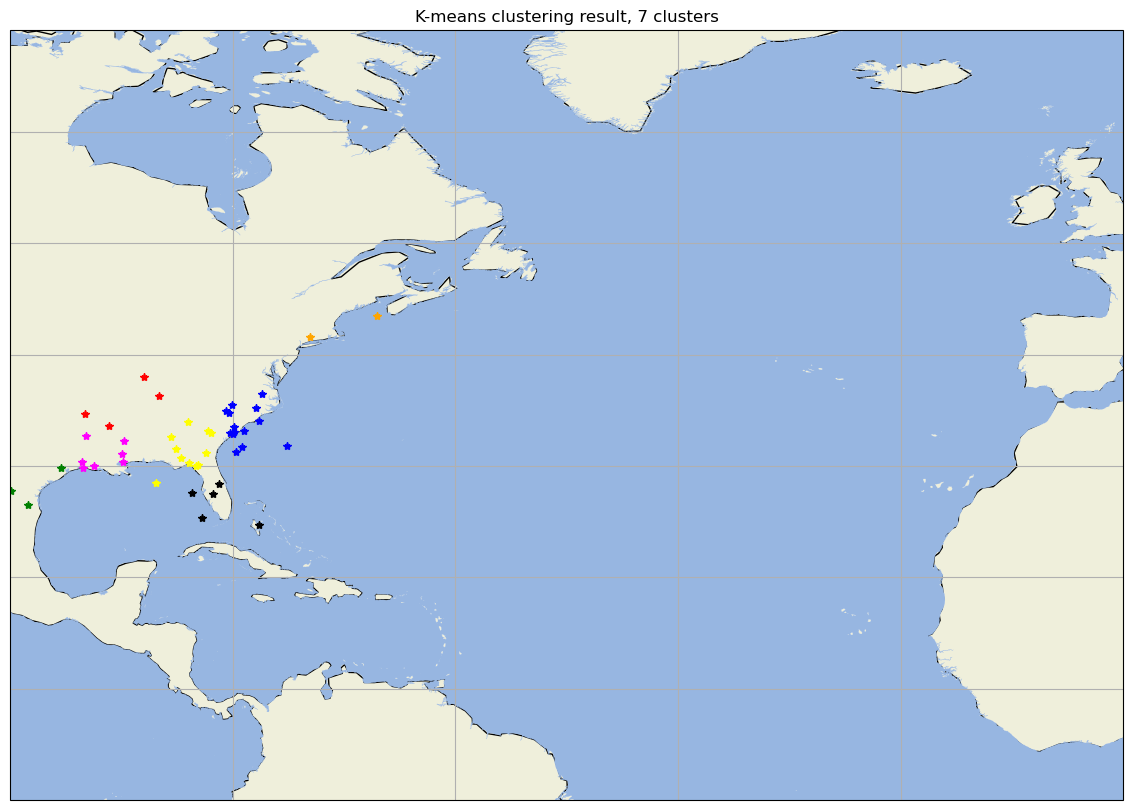

In [31]:
#Cluster by landfall location only
km_landfall_spat = k_means(moment_landfall_spat, n_clusters=7)
# print(km[0])

colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta', 'orange', 'white', 'purple', 'teal']
labels_landfall_spat = km_landfall_spat[1]
ax = map_background()
for k in range(len(filtered_moment_landfall)):
    ax.plot(moment_landfall_spat[k][0], moment_landfall_spat[k][1], c=colors[labels_landfall_spat[k]], marker='*')
plt.title('K-means clustering result, 7 clusters')

In [32]:
#Get rid of storms in the filtered (landfall, years, and CONUS) dataset which have only one lon/lat on landfall track
def is_valid_landfall_storm(storm):
    lon_lst, lat_lst = get_landfall_lon_lat(storm)
    return len(lon_lst) > 1  # Keep only storms with more than one point

# Get a list of valid storm indices
valid_storms = [i for i in range(filtered_tks2.dims['storm']) if is_valid_landfall_storm(filtered_tks2.sel(storm=i))]

# Filter the xarray dataset to only keep valid storms
filtered_tks3 = filtered_tks2.sel(storm=xr.DataArray(valid_storms, dims="storm"))
len(valid_storms)

58

In [33]:
#Add the first two moments (lat and long of ellipse) to the filtered (landfall, years, and CONUS) dataset
moment_landfall_array = np.array(moment_landfall)
moment_lon = moment_landfall_array[:, 0]
moment_lat = moment_landfall_array[:, 1]

temp_array  = filtered_tks3.assign_coords(moment_lat=('storm', moment_lat))
full_array  = temp_array.assign_coords(moment_lon=('storm', moment_lon))

In [34]:
#Need to filter the full_array to include only storms with moment_lat and moment_lon in the CONUS box
longitude_boundary = -66.9503  
latitude_boundary = 24.5465 
# Filter the full_array to include only storms with moment_lat and moment_lon in the CONUS box
conus_mask = (full_array.moment_lon <= longitude_boundary) & (full_array.moment_lat >= latitude_boundary)

# Extract the storm IDs that pass through the boundary
storms_within_boundary = full_array.storm[conus_mask]

# Filter the dataset to include only these storms
full_array_filtered = full_array.sel(storm=storms_within_boundary)

In [35]:
#Add the clustering labels to the filtered full array for post-clustering analyses
full_array_templabeled  = full_array_filtered.assign_coords(fullmoment_label=('storm', labels_landfall_filt))
full_array_labeled = full_array_templabeled.assign_coords(spatmoment_label=('storm', labels_landfall_spat))


In [36]:
#Group the full labeled dataset by variables we want to plot
grouped_whole = full_array_labeled.groupby('fullmoment_label')
grouped_spat = full_array_labeled.groupby('spatmoment_label')
summary_whole = grouped_whole.mean(dim='storm')
summary_spat = grouped_spat.mean(dim='storm')

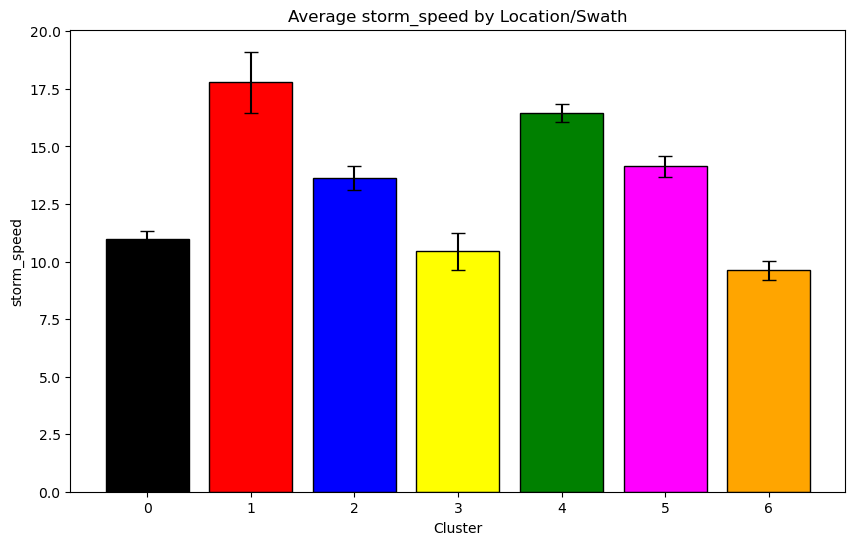

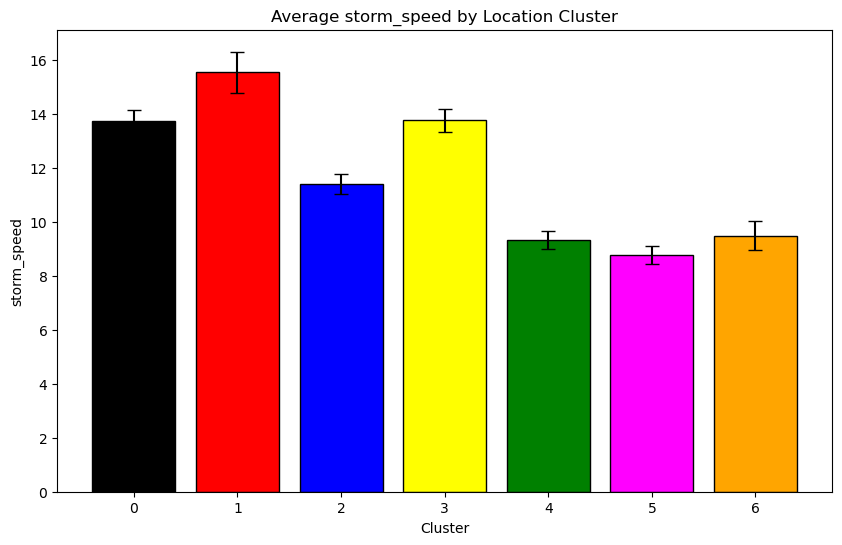

In [37]:
#Plot variables by cluster
# Define the list of colors
colors = ['black', 'red', 'blue', 'yellow', 'green', 'magenta', 'orange', 'white', 'purple', 'teal']

# Function to plot bar plot with specified colors and error bars
def plot_bar_with_error(data_to_plot, errors, title):
    plt.figure(figsize=(10, 6))
    num_bars = len(data_to_plot)
    bar_colors = [colors[i % len(colors)] for i in range(num_bars)]
    plt.bar(range(num_bars), data_to_plot, yerr=errors, capsize=5, color=bar_colors, edgecolor='black')
    plt.xlabel('Cluster')
    plt.ylabel(data_variable)
    plt.title(title)
    plt.xticks(range(num_bars), labels=range(num_bars))
    plt.show()

# Calculate mean and standard error for summary_whole
data_variable = 'storm_speed'
mean_whole = summary_whole[data_variable].mean(dim='date_time').values
std_whole = summary_whole[data_variable].std(dim='date_time').values
count_whole = summary_whole[data_variable].count(dim='date_time').values
stderr_whole = std_whole / np.sqrt(count_whole)

# Plot for summary_whole
plot_bar_with_error(mean_whole, stderr_whole, f'Average {data_variable} by Location/Swath')

# Calculate mean and standard error for summary_spat
mean_spat = summary_spat[data_variable].mean(dim='date_time').values
std_spat = summary_spat[data_variable].std(dim='date_time').values
count_spat = summary_spat[data_variable].count(dim='date_time').values
stderr_spat = std_spat / np.sqrt(count_spat)

# Plot for summary_spat
plot_bar_with_error(mean_spat, stderr_spat, f'Average {data_variable} by Location Cluster')

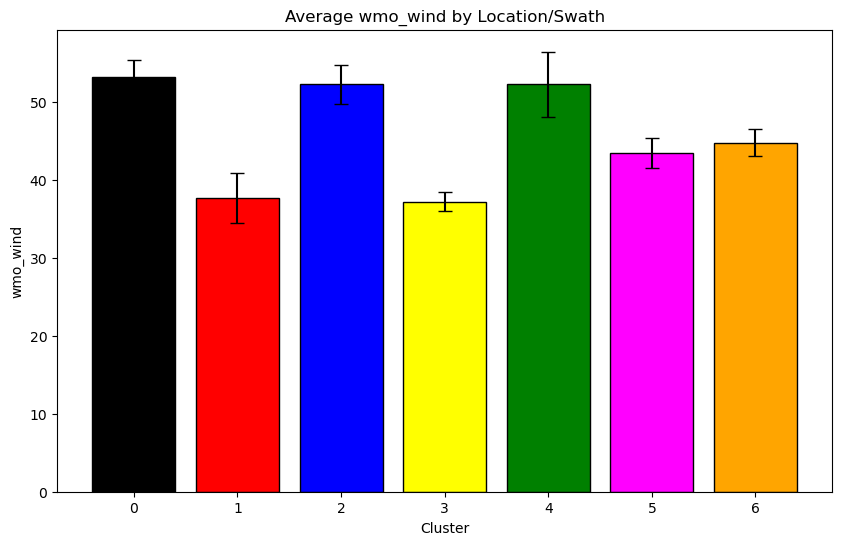

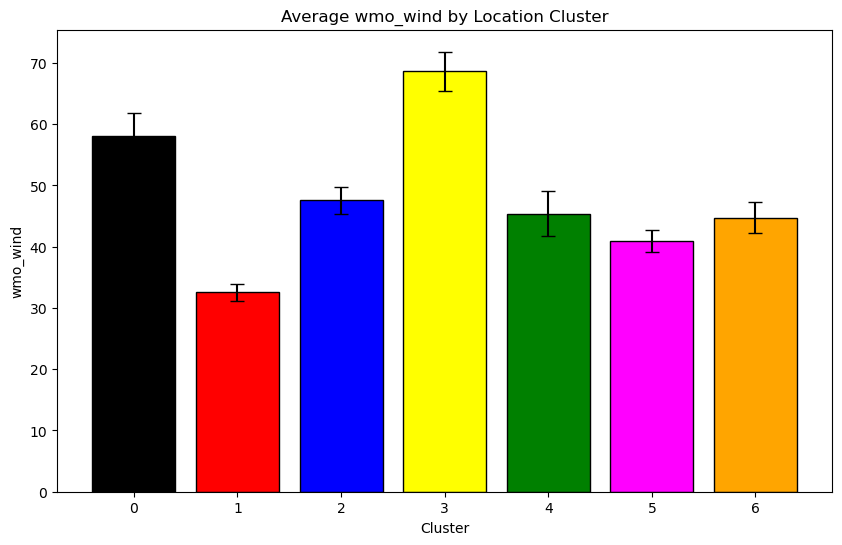

In [38]:
# Calculate mean and standard error for summary_whole
data_variable = 'wmo_wind'
mean_whole = summary_whole[data_variable].mean(dim='date_time').values
std_whole = summary_whole[data_variable].std(dim='date_time').values
count_whole = summary_whole[data_variable].count(dim='date_time').values
stderr_whole = std_whole / np.sqrt(count_whole)

# Plot for summary_whole
plot_bar_with_error(mean_whole, stderr_whole, f'Average {data_variable} by Location/Swath')

# Calculate mean and standard error for summary_spat
mean_spat = summary_spat[data_variable].mean(dim='date_time').values
std_spat = summary_spat[data_variable].std(dim='date_time').values
count_spat = summary_spat[data_variable].count(dim='date_time').values
stderr_spat = std_spat / np.sqrt(count_spat)

# Plot for summary_spat
plot_bar_with_error(mean_spat, stderr_spat, f'Average {data_variable} by Location Cluster')

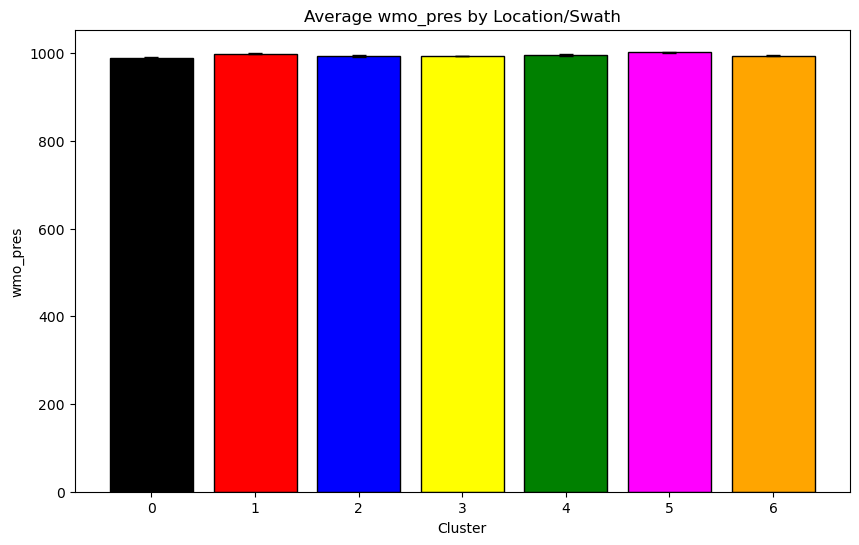

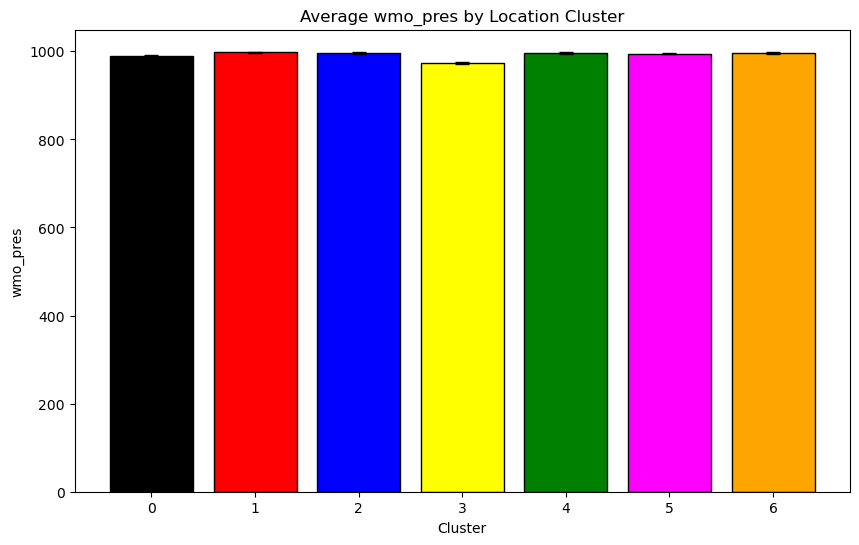

In [39]:
# Calculate mean and standard error for summary_whole
data_variable = 'wmo_pres'
mean_whole = summary_whole[data_variable].mean(dim='date_time').values
std_whole = summary_whole[data_variable].std(dim='date_time').values
count_whole = summary_whole[data_variable].count(dim='date_time').values
stderr_whole = std_whole / np.sqrt(count_whole)

# Plot for summary_whole
plot_bar_with_error(mean_whole, stderr_whole, f'Average {data_variable} by Location/Swath')

# Calculate mean and standard error for summary_spat
mean_spat = summary_spat[data_variable].mean(dim='date_time').values
std_spat = summary_spat[data_variable].std(dim='date_time').values
count_spat = summary_spat[data_variable].count(dim='date_time').values
stderr_spat = std_spat / np.sqrt(count_spat)

# Plot for summary_spat
plot_bar_with_error(mean_spat, stderr_spat, f'Average {data_variable} by Location Cluster')

In [40]:
print(full_array_labeled)

<xarray.Dataset> Size: 12MB
Dimensions:           (storm: 46, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) float64 132kB 5.684e+04 ... nan
    lat               (storm, date_time) float32 66kB 32.0 31.6 31.2 ... nan nan
    lon               (storm, date_time) float32 66kB -78.2 -78.0 ... nan nan
    moment_lat        (storm) float64 368B 43.48 35.19 34.64 ... 31.18 36.48
    moment_lon        (storm) float64 368B -67.0 -77.94 -93.28 ... -82.41 -77.34
    fullmoment_label  (storm) int32 184B 2 0 6 0 0 6 0 6 0 ... 0 0 6 0 6 0 0 0 0
    spatmoment_label  (storm) int32 184B 6 2 1 2 3 2 2 1 0 ... 3 5 0 2 0 3 4 3 2
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/147)
    numobs            (storm) float32 184B 91.0 54.0 42.0 ... 17.0 104.0 28.0
    sid               (storm) |S13 598B b'2014180N32282' ... b'2023265N29284'
    season            (storm) float32 184B 2.014e+03 2.015e+03 ... 2.023e+03
    number            (stor

In [57]:
import pandas as pd
from cftime import num2date


def get_landfall_times(storm):
    landfall_times = storm.time.where(storm.landfall == 0, drop=True)
    if landfall_times.size > 0:
        first_landfall_time = landfall_times[0].item()
        final_landfall_time = landfall_times[-1].item()
        return first_landfall_time, final_landfall_time
    else:
        return None, None

# Convert numeric time to datetime
def convert_time(numeric_time, units, calendar):
    return num2date(numeric_time, units, calendar).strftime('%Y-%m-%d %H:%M:%S')

# Get the time units and calendar from the dataset
time_units = full_array_labelled.time.attrs['units']
time_calendar = full_array_labelled.time.attrs.get('calendar', 'standard')

# Apply the function to each storm
results = []
for storm_id in full_array_labeled.storm.values:
    storm = full_array_labelled.sel(storm=storm_id)
    first_landfall_time, final_landfall_time = get_landfall_times(storm)
    if first_landfall_time is not None:
        results.append({
            'storm': storm_id,
            'storm_name': storm.sid.item().decode('utf-8'),  # Decode the byte string to a regular string
            'fullmoment_label': storm.fullmoment_label.item(),
            'spatmoment_label': storm.spatmoment_label.item(),
            'first_landfall_time': convert_time(first_landfall_time, time_units, time_calendar),
            'final_landfall_time': convert_time(final_landfall_time, time_units, time_calendar)
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the result
print(results_df)

NameError: name 'full_array_labelled' is not defined

In [54]:
(results_df)

NameError: name 'head' is not defined

NameError: name 'unique' is not defined